In [ ]:
# Complete Jet Generation Pipeline with Sequential Processing (Enhanced Decoder)
# Combines graph neural networks, diffusion models, and improved decoders for jet generation

# Install required packages
!pip install torch torch-geometric torch-scatter torch-sparse torch-cluster torch-spline-conv -f https://data.pyg.org/whl/torch-2.0.0+cpu.html
!pip install networkx scikit-learn pyarrow pandas

import pandas as pd
import numpy as np
import networkx as nx
from sklearn.neighbors import kneighbors_graph
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch_geometric.data import Data, Batch
from torch_geometric.nn import ChebConv
import matplotlib.pyplot as plt
from torch_geometric.loader import DataLoader as GeometricDataLoader

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# --- 1. Data Loading and Preprocessing ---

def load_and_prepare_data(file_path1, file_path2):
    """Load parquet file and reshape jets"""
    df = pd.read_parquet(file_path1, engine='pyarrow')
    print("Data loaded!")

    df2 = pd.read_parquet(file_path2, engine='pyarrow')
    print("Data loaded!")

    all_x_jets = pd.concat([df['X_jets'], df2['X_jets']], ignore_index=True)
    print(f"Total number of jets in dataset: {len(all_x_jets)}")

    # Reshape all jets
    reshaped_jets = []
    for idx, jet in enumerate(all_x_jets[:3200]):
        try:
            reshaped = jet.reshape((125, 1000))
            reshaped_jets.append(reshaped)
        except Exception as e:
            print(f"Error reshaping jet {idx}: {e}")
            continue

    print(f"Successfully reshaped {len(reshaped_jets)} jets")
    return reshaped_jets

def get_hits(jet_array):
    """Extract hits from jet array"""
    indices = np.nonzero(jet_array)
    x = indices[0]
    y = indices[1]
    energy = jet_array[indices]
    hits = np.vstack((x, y, energy)).T
    return hits

def make_graph(hits):
    """Create graph from hits using k-nearest neighbors"""
    coords = hits[:, :2]
    adj_matrix = kneighbors_graph(coords, n_neighbors=4, mode='connectivity', include_self=False)
    G = nx.from_scipy_sparse_array(adj_matrix)
    return G, hits, adj_matrix


def process_jets_sequential(reshaped_jets, model):
    """Sequential processing approach that works reliably"""
    all_pooled_embeddings = []
    all_jets = []
    failed_count = 0

    print(f"Processing {len(reshaped_jets)} jets for diffusion model training...")

    for i, jet in enumerate(reshaped_jets):
        if i % 100 == 0:  # Progress indicator
            print(f"Processing jet {i}/{len(reshaped_jets)}...")

        try:
            hits = get_hits(jet)
            if hits is None or len(hits) == 0:
                failed_count += 1
                continue

            G, hits, adj_matrix = make_graph(hits)

            # Create graph data
            x = torch.tensor(hits, dtype=torch.float)
            edge_index = torch.tensor(np.array(np.nonzero(adj_matrix)), dtype=torch.long)

            # Get node embeddings
            with torch.no_grad():
                node_embeddings = model(x.to(device), edge_index.to(device))
                node_embeddings = node_embeddings.cpu().numpy()

            # Pool embeddings (mean pooling)
            pooled_embedding = node_embeddings.mean(axis=0)
            all_pooled_embeddings.append(pooled_embedding)
            all_jets.append(jet)  # shape (125, 1000)

        except Exception as e:
            print(f"Error processing jet {i}: {e}")
            failed_count += 1
            continue

    # Convert to numpy arrays
    all_pooled_embeddings = np.stack(all_pooled_embeddings)
    all_jets = np.stack(all_jets)

    print(f"\nProcessing complete!")
    print(f"Successfully processed: {len(all_pooled_embeddings)} jets")
    print(f"Failed: {failed_count} jets")
    print(f"Pooled embeddings shape: {all_pooled_embeddings.shape}")
    print(f"All jets shape: {all_jets.shape}")

    return all_pooled_embeddings, all_jets


Looking in links: https://data.pyg.org/whl/torch-2.0.0+cpu.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.0/494.0 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 750.9/750.9 kB 23.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 208.1/208.1 kB 422.2 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 79.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 60.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB

/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_scatter/_version_cpu.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:97: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_cluster/_version_cpu.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-cluster'. "
/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:113: UserWarning: An issue occurred while importing 'torch-spline-conv'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_spline_conv/_version_cpu.so: undefined symbol: _ZN3c1017RegisterOp

Using device: cuda


In [ ]:
# --- 2. Graph Neural Network Model ---

class SimpleChebNet(nn.Module):
    def __init__(self, in_dim=3, hidden_dim=32, K=3, out_dim=16):
        super().__init__()
        self.conv1 = ChebConv(in_dim, hidden_dim, K)
        self.conv2 = ChebConv(hidden_dim, hidden_dim, K)
        self.conv3 = ChebConv(hidden_dim, out_dim, K)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)

    def forward(self, x, edge_index, batch=None):
        x = self.conv1(x, edge_index)
        x = self.bn1(F.leaky_relu(x))
        x = self.conv2(x, edge_index)
        x = self.bn2(F.leaky_relu(x))
        x = self.conv3(x, edge_index)
        x = F.normalize(x, p=2, dim=1)  # L2 normalize embeddings
        return x


In [ ]:
# --- 4. Diffusion Model with Batching ---

class SimpleDiffusionMLP(nn.Module):
    def __init__(self, emb_dim, hidden_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(emb_dim+1, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, emb_dim)
        )

    def forward(self, x, t):
        # x: [batch, emb_dim], t: [batch, 1]
        xt = torch.cat([x, t], dim=1)
        return self.net(xt)

class DiffusionDataset(Dataset):
    def __init__(self, embeddings):
        self.embeddings = torch.tensor(embeddings, dtype=torch.float32)

    def __len__(self):
        return len(self.embeddings)

    def __getitem__(self, idx):
        return self.embeddings[idx]

def train_diffusion_model_batched(embeddings, n_steps=1000, epochs=100, batch_size=8):
    """Train diffusion model on embeddings with proper batching"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    emb_dim = embeddings.shape[1]
    model = SimpleDiffusionMLP(emb_dim).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    # Create dataset and dataloader
    dataset = DiffusionDataset(embeddings)
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=0,
        pin_memory=True if device.type == 'cuda' else False
    )

    print(f"Training diffusion model with {len(embeddings)} embeddings...")
    print(f"Batch size: {batch_size}, Batches per epoch: {len(dataloader)}")

    model.train()

    for epoch in range(epochs):
        epoch_loss = 0.0
        num_batches = 0

        for batch_idx, batch in enumerate(dataloader):
            batch = batch.to(device, non_blocking=True)
            batch_size_actual = batch.size(0)

            # Random time steps for each sample in batch
            t = torch.rand((batch_size_actual, 1), device=device)

            # Add noise
            noise = torch.randn_like(batch)
            noisy = batch + noise * t  # simple noise schedule

            # Predict noise
            pred_noise = model(noisy, t)
            loss = ((pred_noise - noise)**2).mean()

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()

            epoch_loss += loss.item()
            num_batches += 1

            # Clear cache periodically
            if batch_idx % 10 == 0:
                torch.cuda.empty_cache()

        avg_loss = epoch_loss / num_batches
        if epoch % 10 == 0:
            print(f"Diffusion Epoch {epoch}/{epochs}, Loss: {avg_loss:.4f}")

        # Clear cache at end of epoch
        torch.cuda.empty_cache()

    return model

def sample_diffusion_model_batched(model, emb_dim, n_samples=10, n_steps=50, batch_size=8):
    """Sample new embeddings from trained diffusion model with batching"""
    device = next(model.parameters()).device
    model.eval()

    all_samples = []

    with torch.no_grad():
        # Process samples in batches
        for i in range(0, n_samples, batch_size):
            current_batch_size = min(batch_size, n_samples - i)
            x = torch.randn((current_batch_size, emb_dim), device=device)

            # Diffusion sampling loop
            for step in reversed(range(n_steps)):
                t = torch.full((current_batch_size, 1), step/n_steps, device=device)
                noise_pred = model(x, t)
                x = x - noise_pred * 0.1  # simple Euler step

            all_samples.append(x.cpu().numpy())

    # Concatenate all batches
    return np.concatenate(all_samples, axis=0)

In [ ]:
# --- 5. Enhanced Decoder Model ---

class JetDataset(Dataset):
    def __init__(self, pooled_embeddings, jets):
        self.pooled_embeddings = pooled_embeddings
        self.jets = jets

    def __len__(self):
        return len(self.pooled_embeddings)

    def __getitem__(self, idx):
        return (
            torch.tensor(self.pooled_embeddings[idx], dtype=torch.float32),
            torch.tensor(self.jets[idx], dtype=torch.float32)
        )

class EnhancedDecoderMLP(nn.Module):
    def __init__(self, emb_dim, grid_shape, hidden_dims=[256, 512]):
        super().__init__()
        self.grid_shape = grid_shape
        self.output_size = grid_shape[0] * grid_shape[1]

        # Build progressive layers - much smaller for T4 GPU
        layers = []
        current_dim = emb_dim

        # Input projection
        layers.extend([
            nn.Linear(current_dim, hidden_dims[0]),
            nn.BatchNorm1d(hidden_dims[0]),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.1)
        ])
        current_dim = hidden_dims[0]

        # Single expansion layer
        layers.extend([
            nn.Linear(current_dim, hidden_dims[1]),
            nn.BatchNorm1d(hidden_dims[1]),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.1)
        ])
        current_dim = hidden_dims[1]

        # Output layer
        layers.extend([
            nn.Linear(current_dim, self.output_size)
        ])

        self.main_net = nn.Sequential(*layers)

        # Smaller residual connection
        self.residual_projection = nn.Sequential(
            nn.Linear(emb_dim, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, self.output_size)
        )

        # Initialize weights
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            # Xavier/Glorot initialization
            nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                nn.init.constant_(module.bias, 0)
        elif isinstance(module, nn.BatchNorm1d):
            nn.init.constant_(module.weight, 1)
            nn.init.constant_(module.bias, 0)

    def forward(self, z):
        # Main path
        main_out = self.main_net(z)

        # Residual path
        residual_out = self.residual_projection(z)

        # Combine with learnable weight
        combined = main_out + 0.1 * residual_out  # Small residual contribution

        # Apply softmax to encourage sparsity (jets are mostly zeros)
        combined = combined.view(-1, *self.grid_shape)

        # Apply ReLU to ensure non-negative energies
        output = F.relu(combined)

        return output

def train_decoder(pooled_embeddings, jets, grid_shape, epochs=200, batch_size=8):
    """Train enhanced decoder to reconstruct jets from embeddings"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Training enhanced decoder on device: {device}")

    # Create dataset and dataloader
    dataset = JetDataset(pooled_embeddings, jets)
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=0,
        pin_memory=True if device.type == 'cuda' else False
    )

    # Initialize smaller model for T4 GPU
    model = EnhancedDecoderMLP(pooled_embeddings.shape[1], grid_shape).to(device)

    # Optimizer with lower learning rate for stability
    optimizer = optim.AdamW(model.parameters(), lr=0.002, weight_decay=1e-4, betas=(0.9, 0.999))

    # Combined loss function
    mse_criterion = nn.MSELoss()
    l1_criterion = nn.L1Loss()

    # More conservative scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 'min', patience=15, factor=0.8, min_lr=1e-6, verbose=True
    )

    print(f"Training enhanced decoder with {len(dataset)} samples, batch size {batch_size}")
    print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

    # Training loop with improved loss tracking
    model.train()
    best_loss = float('inf')
    patience_counter = 0

    for epoch in range(epochs):
        epoch_loss = 0.0
        epoch_mse = 0.0
        epoch_l1 = 0.0
        num_batches = 0

        for batch_idx, (z, target) in enumerate(dataloader):
            z = z.to(device, non_blocking=True)
            target = target.to(device, non_blocking=True)

            # Forward pass
            pred = model(z)

            # Combined loss: MSE for overall structure + L1 for sparsity
            mse_loss = mse_criterion(pred, target)
            l1_loss = l1_criterion(pred, target)
            loss = mse_loss + 0.05 * l1_loss  # Reduced L1 weight

            # Backward pass
            optimizer.zero_grad()
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()

            epoch_loss += loss.item()
            epoch_mse += mse_loss.item()
            epoch_l1 += l1_loss.item()
            num_batches += 1

            # Clear cache more frequently for memory management
            if batch_idx % 5 == 0:
                torch.cuda.empty_cache()

        avg_loss = epoch_loss / num_batches
        avg_mse = epoch_mse / num_batches
        avg_l1 = epoch_l1 / num_batches

        # Step scheduler
        scheduler.step(avg_loss)

        # Early stopping check
        if avg_loss < best_loss:
            best_loss = avg_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if epoch % 10 == 0:
            print(f"Decoder Epoch {epoch}/{epochs}")
            print(f"  Total Loss: {avg_loss:.6f}, MSE: {avg_mse:.6f}, L1: {avg_l1:.6f}")
            print(f"  LR: {optimizer.param_groups[0]['lr']:.8f}")
            print(f"  Best Loss: {best_loss:.6f}, Patience: {patience_counter}")

        # Early stopping
        if patience_counter >= 30:
            print(f"Early stopping at epoch {epoch}")
            break

        torch.cuda.empty_cache()

    return model

In [ ]:
# --- 6. Visualization Functions ---

def visualize_jets(jets, titles, n_cols=2):
    """Visualize multiple jets in a grid with clean white background"""
    n_jets = len(jets)
    n_rows = (n_jets + n_cols - 1) // n_cols

    # Set up clean style
    plt.style.use('default')
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12 * n_cols, 4 * n_rows))
    fig.patch.set_facecolor('white')

    # Create custom colormap
    from matplotlib.colors import LinearSegmentedColormap
    colors = ['white', '#440154', '#31688e', '#35b779', '#fde725']
    cmap = LinearSegmentedColormap.from_list('custom_viridis', colors, N=256)

    # Handle single row case
    if n_rows == 1:
        axes = axes.reshape(1, -1) if n_cols > 1 else [axes]
    elif n_cols == 1:
        axes = axes.reshape(-1, 1)

    for i, (jet, title) in enumerate(zip(jets, titles)):
        row = i // n_cols
        col = i % n_cols
        ax = axes[row, col] if n_rows > 1 else axes[col]

        # Plot with consistent scaling
        vmin, vmax = 0, jet.max()
        im = ax.imshow(jet, aspect='auto', origin='lower', cmap=cmap, vmin=vmin, vmax=vmax)

        # Style the plot
        ax.set_title(title, fontsize=12, fontweight='bold', pad=10)
        ax.set_xlabel('η', fontsize=10)
        ax.set_ylabel('φ', fontsize=10)
        ax.grid(True, alpha=0.3, linewidth=0.5)
        ax.set_facecolor('white')

        # Add colorbar
        cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        cbar.set_label('Energy (GeV)', fontsize=10)
        cbar.ax.tick_params(labelsize=8)

        # Style axes
        ax.tick_params(labelsize=8)
        for spine in ax.spines.values():
            spine.set_color('black')
            spine.set_linewidth(1)

    # Hide unused subplots
    for i in range(n_jets, n_rows * n_cols):
        row = i // n_cols
        col = i % n_cols
        ax = axes[row, col] if n_rows > 1 else axes[col]
        ax.set_visible(False)

    plt.tight_layout()
    plt.show()

def compare_reconstruction(original, reconstruction, idx):
    """Compare original jet with decoder reconstruction - clean white background style"""
    # Set up the figure with white background
    plt.style.use('default')  # Reset to default style
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    fig.patch.set_facecolor('white')

    # Create a custom colormap that goes from white to colors (like your reference image)
    from matplotlib.colors import LinearSegmentedColormap
    colors = ['white', '#440154', '#31688e', '#35b779', '#fde725']  # Viridis-like but starting from white
    n_bins = 256
    cmap = LinearSegmentedColormap.from_list('custom_viridis', colors, N=n_bins)

    # Set common vmin/vmax for consistent scaling
    vmin = 0
    vmax = max(original.max(), reconstruction.max())

    # Original jet
    im1 = ax1.imshow(original, aspect='auto', origin='lower', cmap=cmap, vmin=vmin, vmax=vmax)
    ax1.set_title(f'Original Image', fontsize=14, fontweight='bold', pad=15)
    ax1.set_xlabel('η', fontsize=12)
    ax1.set_ylabel('φ', fontsize=12)
    ax1.grid(True, alpha=0.3, linewidth=0.5)
    ax1.set_facecolor('white')

    # Add colorbar for original
    cbar1 = plt.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)
    cbar1.set_label('Energy (GeV)', fontsize=12)
    cbar1.ax.tick_params(labelsize=10)

    # Decoder reconstruction
    im2 = ax2.imshow(reconstruction, aspect='auto', origin='lower', cmap=cmap, vmin=vmin, vmax=vmax)
    ax2.set_title(f'Reconstructed', fontsize=14, fontweight='bold', pad=15)
    ax2.set_xlabel('η', fontsize=12)
    ax2.set_ylabel('φ', fontsize=12)
    ax2.grid(True, alpha=0.3, linewidth=0.5)
    ax2.set_facecolor('white')

    # Add colorbar for reconstruction
    cbar2 = plt.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)
    cbar2.set_label('Energy (GeV)', fontsize=12)
    cbar2.ax.tick_params(labelsize=10)

    # Style the axes
    for ax in [ax1, ax2]:
        ax.tick_params(labelsize=10)
        ax.spines['top'].set_visible(True)
        ax.spines['right'].set_visible(True)
        ax.spines['bottom'].set_visible(True)
        ax.spines['left'].set_visible(True)
        for spine in ax.spines.values():
            spine.set_color('black')
            spine.set_linewidth(1)

    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()

    # Calculate metrics
    mse = np.mean((original - reconstruction)**2)
    mae = np.mean(np.abs(original - reconstruction))
    correlation = np.corrcoef(original.flatten(), reconstruction.flatten())[0, 1]

    print(f"Jet {idx} Reconstruction Metrics:")
    print(f"  MSE: {mse:.6f}")
    print(f"  MAE: {mae:.6f}")
    print(f"  Correlation: {correlation:.4f}")
    print(f"  Original max energy: {original.max():.4f}")
    print(f"  Reconstructed max energy: {reconstruction.max():.4f}")
    print(f"  Original sparsity: {(original == 0).mean():.4f}")
    print(f"  Reconstructed sparsity: {(reconstruction == 0).mean():.4f}")
    print()

Looking in links: https://data.pyg.org/whl/torch-2.0.0+cpu.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.0/494.0 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 750.9/750.9 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 208.1/208.1 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 62.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 M

/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_scatter/_version_cpu.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:97: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_cluster/_version_cpu.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-cluster'. "
/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:113: UserWarning: An issue occurred while importing 'torch-spline-conv'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_spline_conv/_version_cpu.so: undefined symbol: _ZN3c1017RegisterOp

Using device: cuda
=== Loading and preparing data ===
Data loaded!
Data loaded!
Total number of jets in dataset: 6400
Successfully reshaped 3200 jets

=== Initializing graph model ===

=== Processing jets sequentially ===
Processing 3200 jets for diffusion model training...
Processing jet 0/3200...
Processing jet 100/3200...
Processing jet 200/3200...
Processing jet 300/3200...
Processing jet 400/3200...
Processing jet 500/3200...
Processing jet 600/3200...
Processing jet 700/3200...
Processing jet 800/3200...
Processing jet 900/3200...
Processing jet 1000/3200...
Processing jet 1100/3200...
Processing jet 1200/3200...
Processing jet 1300/3200...
Processing jet 1400/3200...
Processing jet 1500/3200...
Processing jet 1600/3200...
Processing jet 1700/3200...
Processing jet 1800/3200...
Processing jet 1900/3200...
Processing jet 2000/3200...
Processing jet 2100/3200...
Processing jet 2200/3200...
Processing jet 2300/3200...
Processing jet 2400/3200...
Processing jet 2500/3200...
Processin

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Training enhanced decoder with 3200 samples, batch size 8
Model parameters: 80,389,648
Decoder Epoch 0/200
  Total Loss: 0.012119, MSE: 0.011799, L1: 0.006403
  LR: 0.00200000
  Best Loss: 0.012119, Patience: 0
Decoder Epoch 10/200
  Total Loss: 0.011529, MSE: 0.011215, L1: 0.006274
  LR: 0.00200000
  Best Loss: 0.011529, Patience: 0
Decoder Epoch 20/200
  Total Loss: 0.011438, MSE: 0.011125, L1: 0.006262
  LR: 0.00200000
  Best Loss: 0.011407, Patience: 2
Decoder Epoch 30/200
  Total Loss: 0.011370, MSE: 0.011057, L1: 0.006263
  LR: 0.00200000
  Best Loss: 0.011360, Patience: 3
Decoder Epoch 40/200
  Total Loss: 0.011349, MSE: 0.011037, L1: 0.006258
  LR: 0.00200000
  Best Loss: 0.011310, Patience: 6
Decoder Epoch 50/200
  Total Loss: 0.011353, MSE: 0.011040, L1: 0.006262
  LR: 0.00200000
  Best Loss: 0.011296, Patience: 4
Decoder Epoch 60/200
  Total Loss: 0.011326, MSE: 0.011013, L1: 0.006263
  LR: 0.00200000
  Best Loss: 0.011275, Patience: 9
Decoder Epoch 70/200
  Total Loss: 0.01

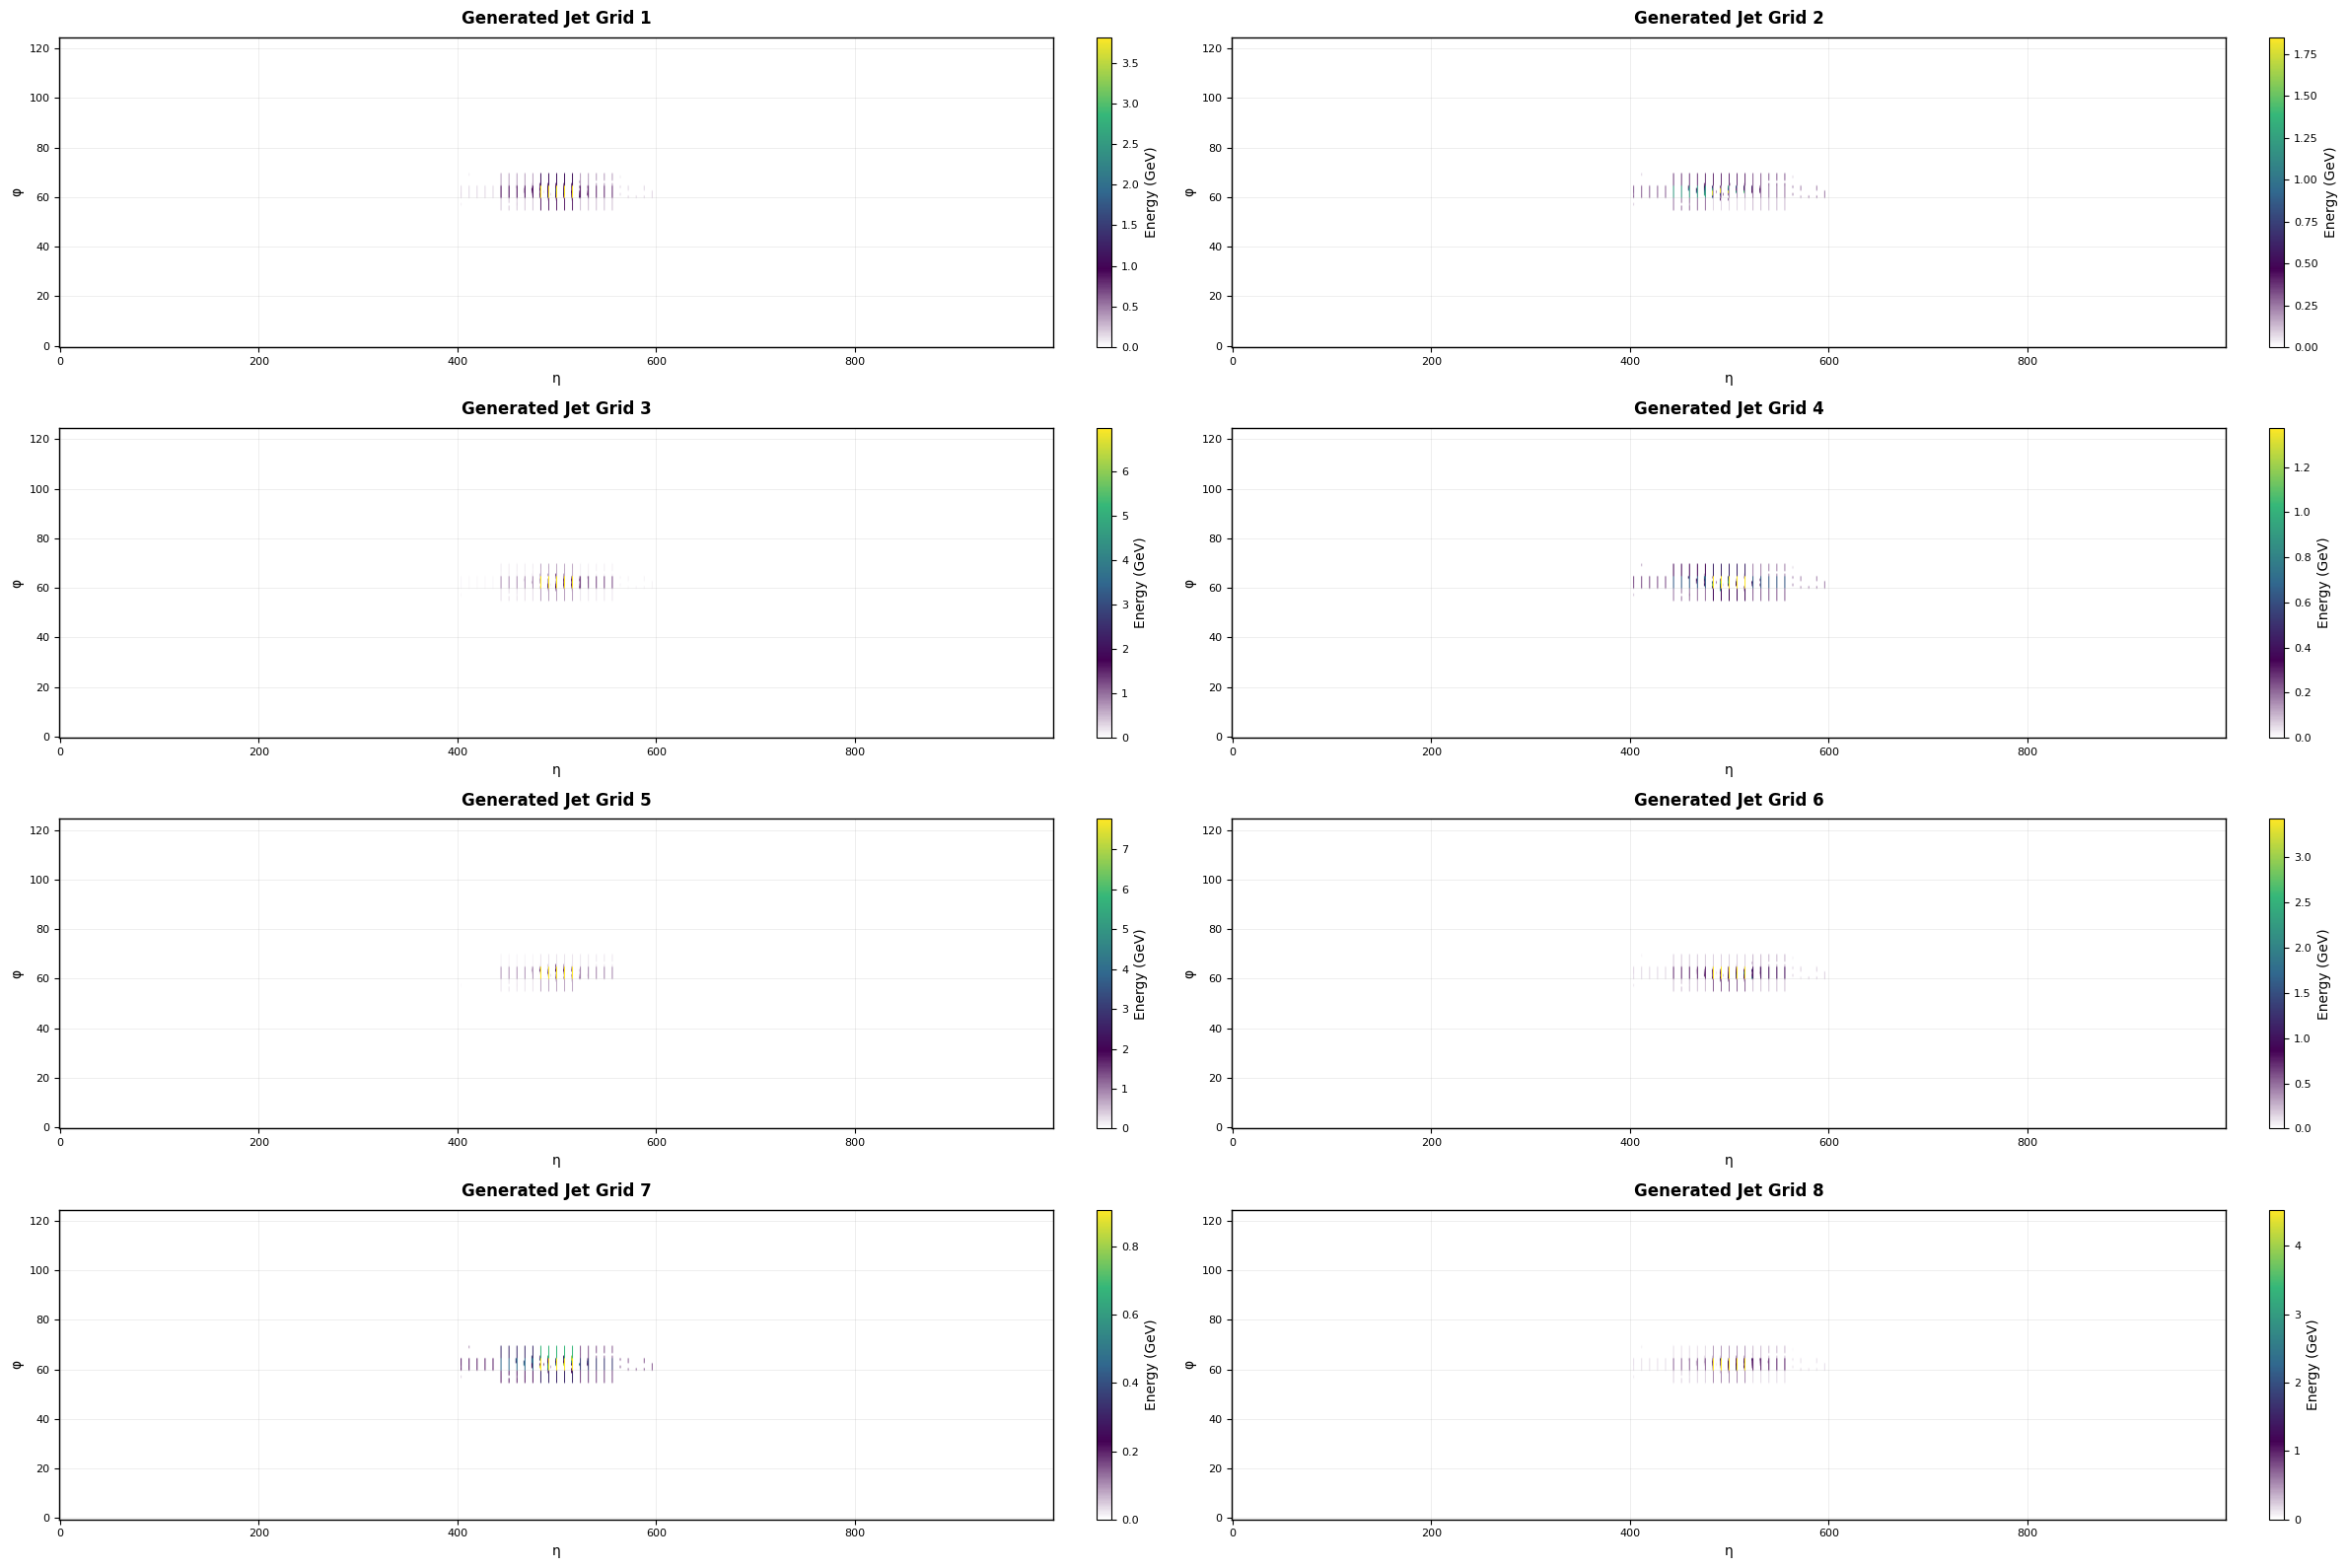


=== Enhanced decoder reconstruction comparison ===


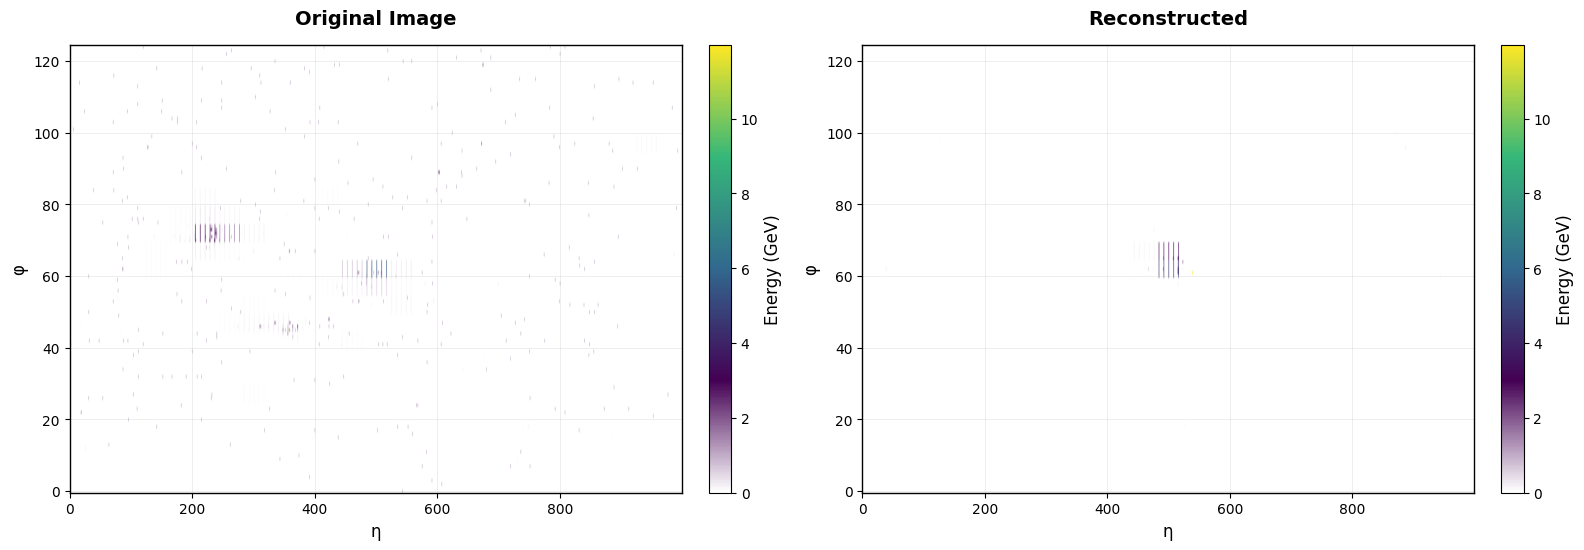

Jet 1 Reconstruction Metrics:
  MSE: 0.010152
  MAE: 0.006360
  Correlation: 0.5172
  Original max energy: 10.3838
  Reconstructed max energy: 11.9641
  Original sparsity: 0.9851
  Reconstructed sparsity: 0.9992



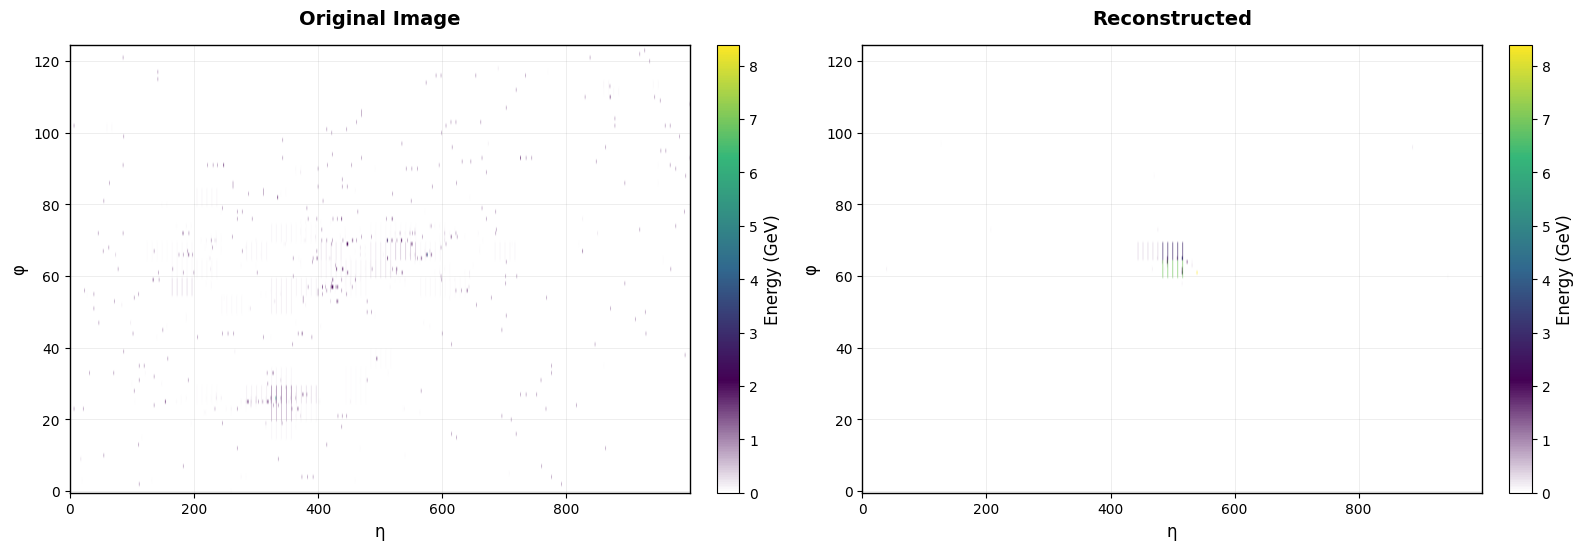

Jet 2 Reconstruction Metrics:
  MSE: 0.015403
  MAE: 0.006887
  Correlation: 0.0741
  Original max energy: 5.3749
  Reconstructed max energy: 8.3874
  Original sparsity: 0.9812
  Reconstructed sparsity: 0.9992



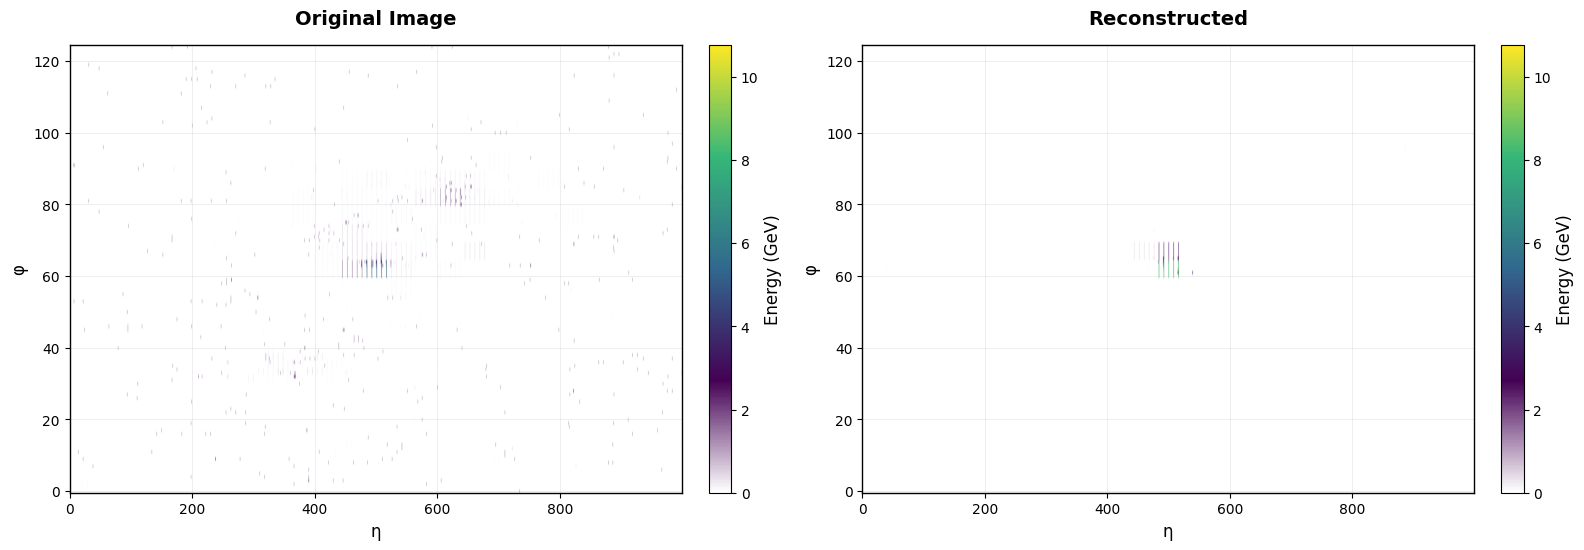

Jet 3 Reconstruction Metrics:
  MSE: 0.007079
  MAE: 0.006278
  Correlation: 0.7500
  Original max energy: 10.7618
  Reconstructed max energy: 8.3519
  Original sparsity: 0.9801
  Reconstructed sparsity: 0.9992


=== Random real jets for comparison ===


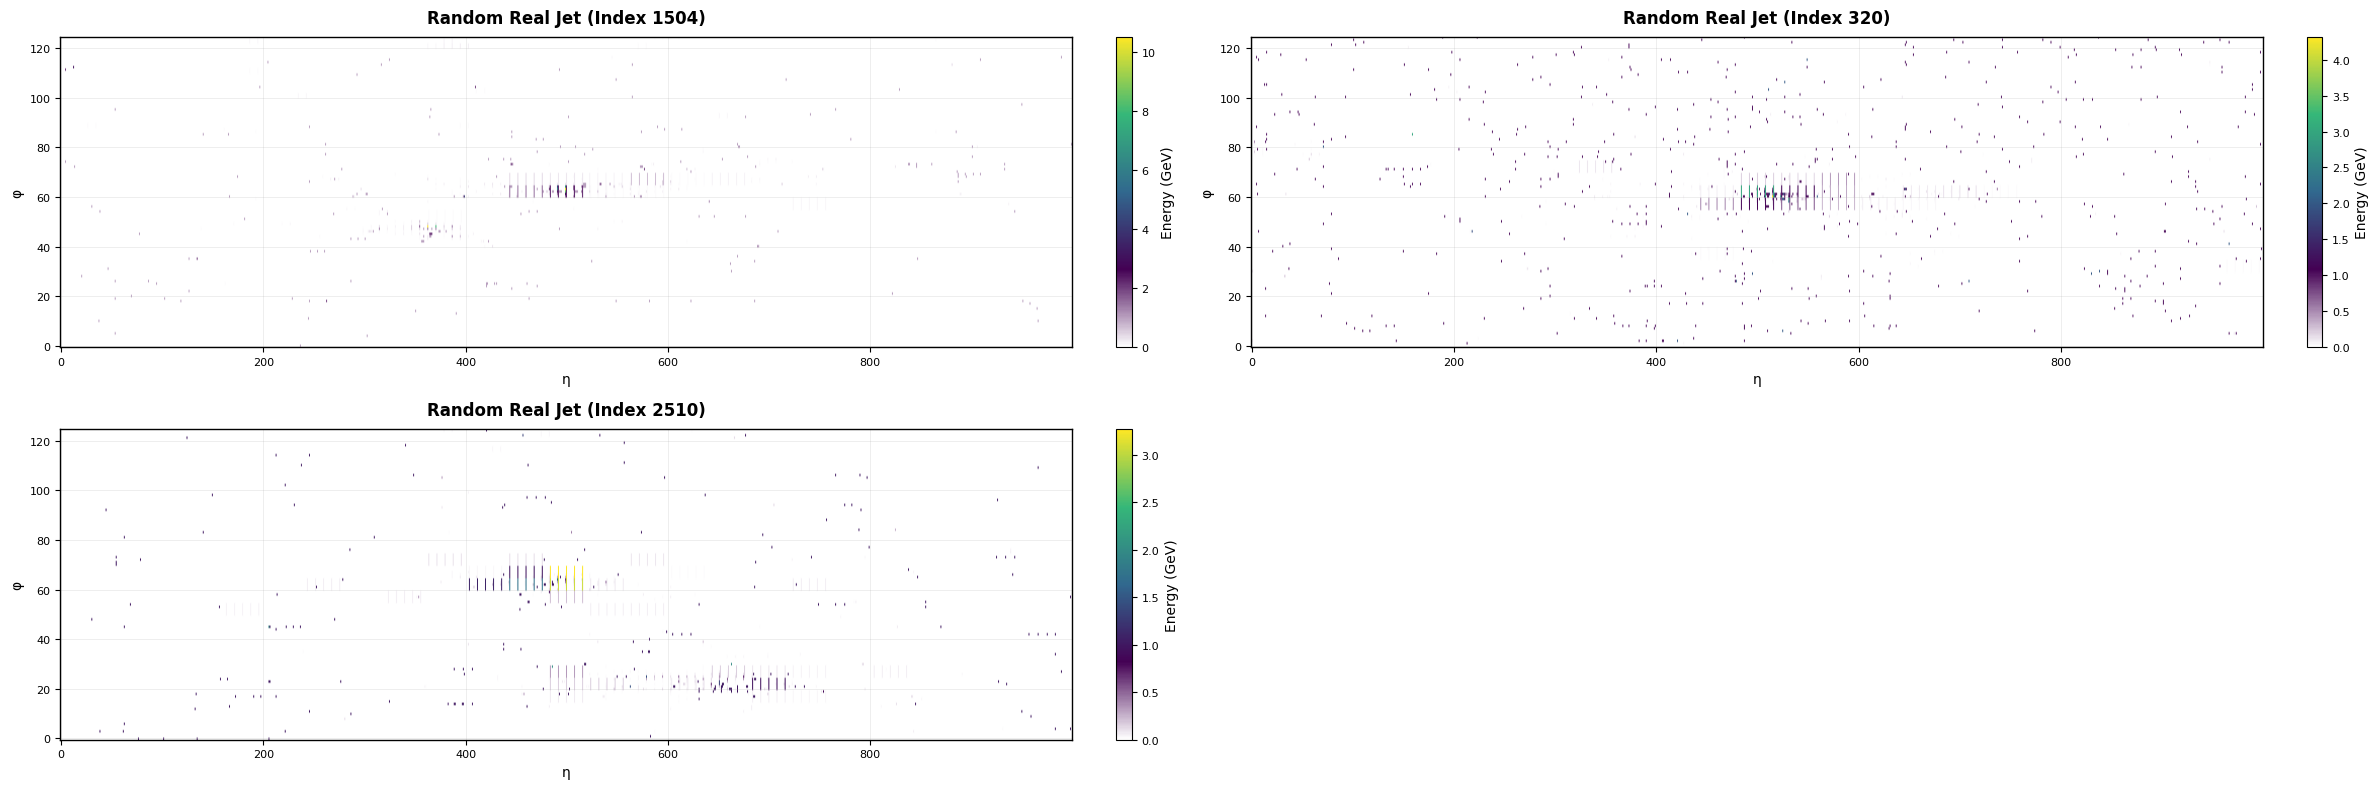


=== Summary ===
Total jets in dataset: 3200
Successfully processed: 3200
Processing success rate: 100.0%
Embedding dimension: 16
Generated samples: 8
Grid shape: (125, 1000)
Batch size used for training: 8

Enhanced sequential pipeline completed successfully!


In [ ]:
 # --- 7. Main Pipeline with Sequential Processing ---

def main_pipeline_sequential(file_path1, file_path2, batch_size=8):
    """Main pipeline using sequential processing for jet embeddings and batching for training"""

    # 1. Load and prepare data
    print("=== Loading and preparing data ===")
    reshaped_jets = load_and_prepare_data(file_path1, file_path2)

    # 2. Initialize graph model
    print("\n=== Initializing graph model ===")
    model = SimpleChebNet(in_dim=3, hidden_dim=32, K=3, out_dim=16).to(device)
    model.eval()  # Using pretrained features

    # 3. Process jets using sequential approach (the working method)
    print(f"\n=== Processing jets sequentially ===")
    all_pooled_embeddings, all_jets = process_jets_sequential(reshaped_jets, model)

    if len(all_pooled_embeddings) == 0:
        print("No jets were successfully processed!")
        return None

    # 4. Train diffusion model with batching
    print(f"\n=== Training diffusion model with batching (batch_size={batch_size}) ===")
    diff_model = train_diffusion_model_batched(
        all_pooled_embeddings, epochs=200, batch_size=batch_size
    )

    # 5. Train enhanced decoder with batching
    print(f"\n=== Training enhanced decoder (batch_size={batch_size}) ===")
    decoder = train_decoder(
        all_pooled_embeddings, all_jets, grid_shape=(125, 1000),
        epochs=200, batch_size=batch_size
    )

    # 6. Generate new samples with batching
    print("\n=== Generating new samples with batching ===")
    n_samples = 8  # Make it a multiple of batch_size for cleaner batching
    new_embeddings = sample_diffusion_model_batched(
        diff_model, emb_dim=all_pooled_embeddings.shape[1],
        n_samples=n_samples, batch_size=batch_size
    )

    with torch.no_grad():
        # Process in batches for decoder as well
        generated_grids = []
        for i in range(0, len(new_embeddings), batch_size):
            batch_embeddings = new_embeddings[i:i+batch_size]
            batch_embeddings_torch = torch.tensor(batch_embeddings, dtype=torch.float32).to(device)
            batch_grids = decoder(batch_embeddings_torch).cpu().numpy()
            generated_grids.append(batch_grids)

        generated_grids = np.concatenate(generated_grids, axis=0)

    # 7. Visualize results
    print(f"\n=== Visualizing {n_samples} generated jet grids ===")
    titles = [f'Generated Jet Grid {i+1}' for i in range(n_samples)]
    visualize_jets(generated_grids, titles)

    # 8. Compare decoder reconstructions
    print("\n=== Enhanced decoder reconstruction comparison ===")
    decoder.eval()  # Set to eval mode to disable BatchNorm training behavior

    # Process multiple jets at once to avoid BatchNorm issues
    n_compare = min(3, len(all_pooled_embeddings))
    comparison_embeddings = all_pooled_embeddings[:n_compare]

    with torch.no_grad():
        comparison_embeddings_torch = torch.tensor(comparison_embeddings, dtype=torch.float32).to(device)
        decoder_reconstructions = decoder(comparison_embeddings_torch).cpu().numpy()

    for i in range(n_compare):
        original_jet = all_jets[i]
        decoder_reconstruction = decoder_reconstructions[i]
        compare_reconstruction(original_jet, decoder_reconstruction, i+1)

    # 9. Show random real jets for comparison
    print("\n=== Random real jets for comparison ===")
    n_compare = 3
    random_indices = np.random.choice(len(all_jets), n_compare, replace=False)
    random_jets = [all_jets[idx] for idx in random_indices]
    random_titles = [f'Random Real Jet (Index {idx})' for idx in random_indices]
    visualize_jets(random_jets, random_titles)

    # 10. Print summary
    print(f"\n=== Summary ===")
    print(f"Total jets in dataset: {len(reshaped_jets)}")
    print(f"Successfully processed: {len(all_pooled_embeddings)}")
    print(f"Processing success rate: {len(all_pooled_embeddings)/len(reshaped_jets)*100:.1f}%")
    print(f"Embedding dimension: {all_pooled_embeddings.shape[1]}")
    print(f"Generated samples: {n_samples}")
    print(f"Grid shape: (125, 1000)")
    print(f"Batch size used for training: {batch_size}")

    return {
        'embeddings': all_pooled_embeddings,
        'jets': all_jets,
        'diffusion_model': diff_model,
        'decoder': decoder,
        'generated_grids': generated_grids
    }

# --- 8. Run the pipeline ---

if __name__ == "__main__":
    # Set your file path here
    file_path1 = '/content/BoostedTop_x1_fixed_1.snappy.parquet'
    file_path2 = '/content/BoostedTop_x1_fixed_0.snappy.parquet'

    # Set batch size for training (not for jet processing which is sequential)
    BATCH_SIZE = 8

    # Run the complete pipeline with sequential jet processing and batched training
    results = main_pipeline_sequential(file_path1, file_path2, batch_size=BATCH_SIZE)

    if results is not None:
        # Optional: Save results
        # np.save('/content/all_pooled_embeddings.npy', results['embeddings'])
        # np.save('/content/all_jets.npy', results['jets'])
        # np.save('/content/generated_jet_grids.npy', results['generated_grids'])
        # torch.save(results['diffusion_model'].state_dict(), '/content/diffusion_model.pth')
        # torch.save(results['decoder'].state_dict(), '/content/decoder_model.pth')

        print("\nEnhanced sequential pipeline completed successfully!")
    else:
        print("\nPipeline failed - no jets were successfully processed.")